In [1]:
# this notebook will use NYC 140 years of daily data of "PRCP", "SNOW", "SNWD", "TMAX", "TMIN" to predict "PRCP"
# Gussian processe will be used to model the residual and use this as uncertainty quantification model
# gussian processes will be used as regression to model the daya


In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import gpytorch
import optuna

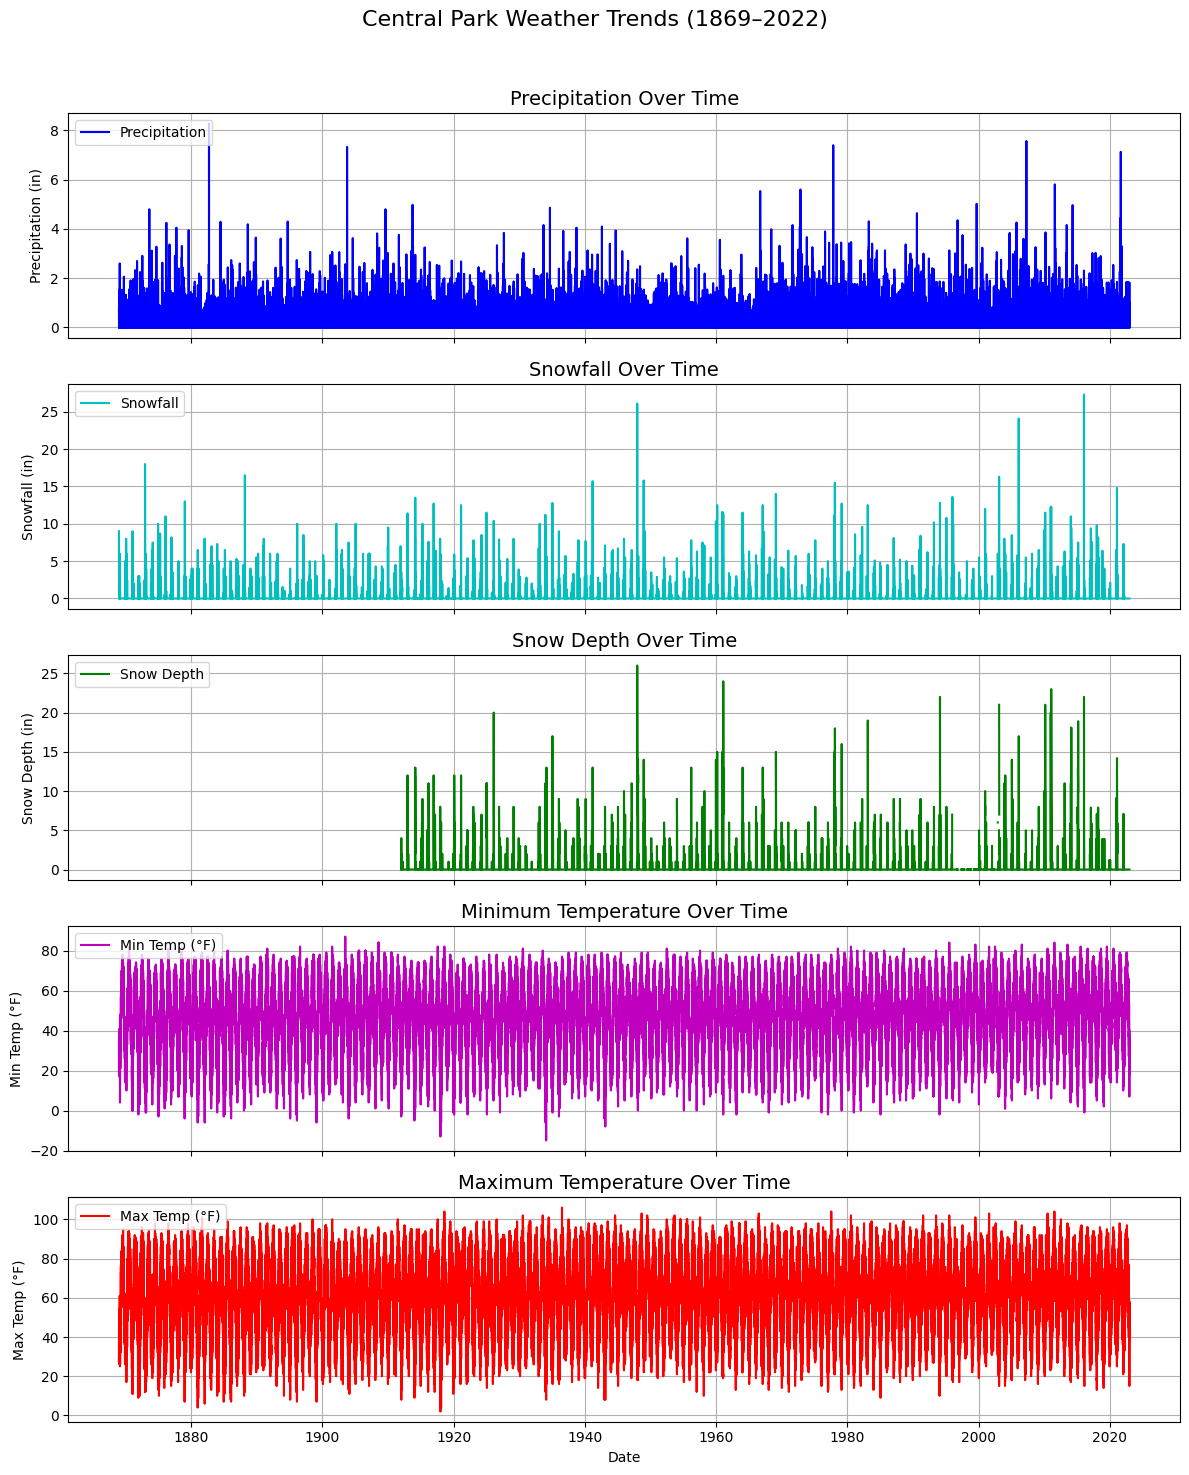

In [2]:
# Define file path and load the dataset
file_path = "data/NYC_Central_Park_weather_1869-2022.csv"
weather_df = pd.read_csv(file_path)

# Convert 'DATE' column to datetime format and set it as the index
weather_df["DATE"] = pd.to_datetime(weather_df["DATE"])
weather_df.set_index("DATE", inplace=True)

# Ensure data is ordered chronologically
weather_df.sort_index(inplace=True)

# Create a figure with five subplots for weather variables
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
fig.suptitle("Central Park Weather Trends (1869–2022)", fontsize=16)

# Plot Precipitation
axes[0].plot(weather_df.index, weather_df['PRCP'], color='b', label='Precipitation')
axes[0].set_ylabel("Precipitation (in)")
axes[0].grid(True)
axes[0].set_title("Precipitation Over Time", fontsize=14)
axes[0].legend(loc='upper left')

# Plot Snowfall
axes[1].plot(weather_df.index, weather_df['SNOW'], color='c', label='Snowfall')
axes[1].set_ylabel("Snowfall (in)")
axes[1].grid(True)
axes[1].set_title("Snowfall Over Time", fontsize=14)
axes[1].legend(loc='upper left')

# Plot Snow Depth
axes[2].plot(weather_df.index, weather_df['SNWD'], color='g', label='Snow Depth')
axes[2].set_ylabel("Snow Depth (in)")
axes[2].grid(True)
axes[2].set_title("Snow Depth Over Time", fontsize=14)
axes[2].legend(loc='upper left')

# Plot Minimum Temperature
axes[3].plot(weather_df.index, weather_df['TMIN'], color='m', label='Min Temp (°F)')
axes[3].set_ylabel("Min Temp (°F)")
axes[3].grid(True)
axes[3].set_title("Minimum Temperature Over Time", fontsize=14)
axes[3].legend(loc='upper left')

# Plot Maximum Temperature
axes[4].plot(weather_df.index, weather_df['TMAX'], color='r', label='Max Temp (°F)')
axes[4].set_ylabel("Max Temp (°F)")
axes[4].set_xlabel("Date")
axes[4].grid(True)
axes[4].set_title("Maximum Temperature Over Time", fontsize=14)
axes[4].legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = "dataset.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/tmp/ipykernel_996141/73058841.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather_df_post_1912 = weather_df_post_1912.resample(temporal_resolution).mean()


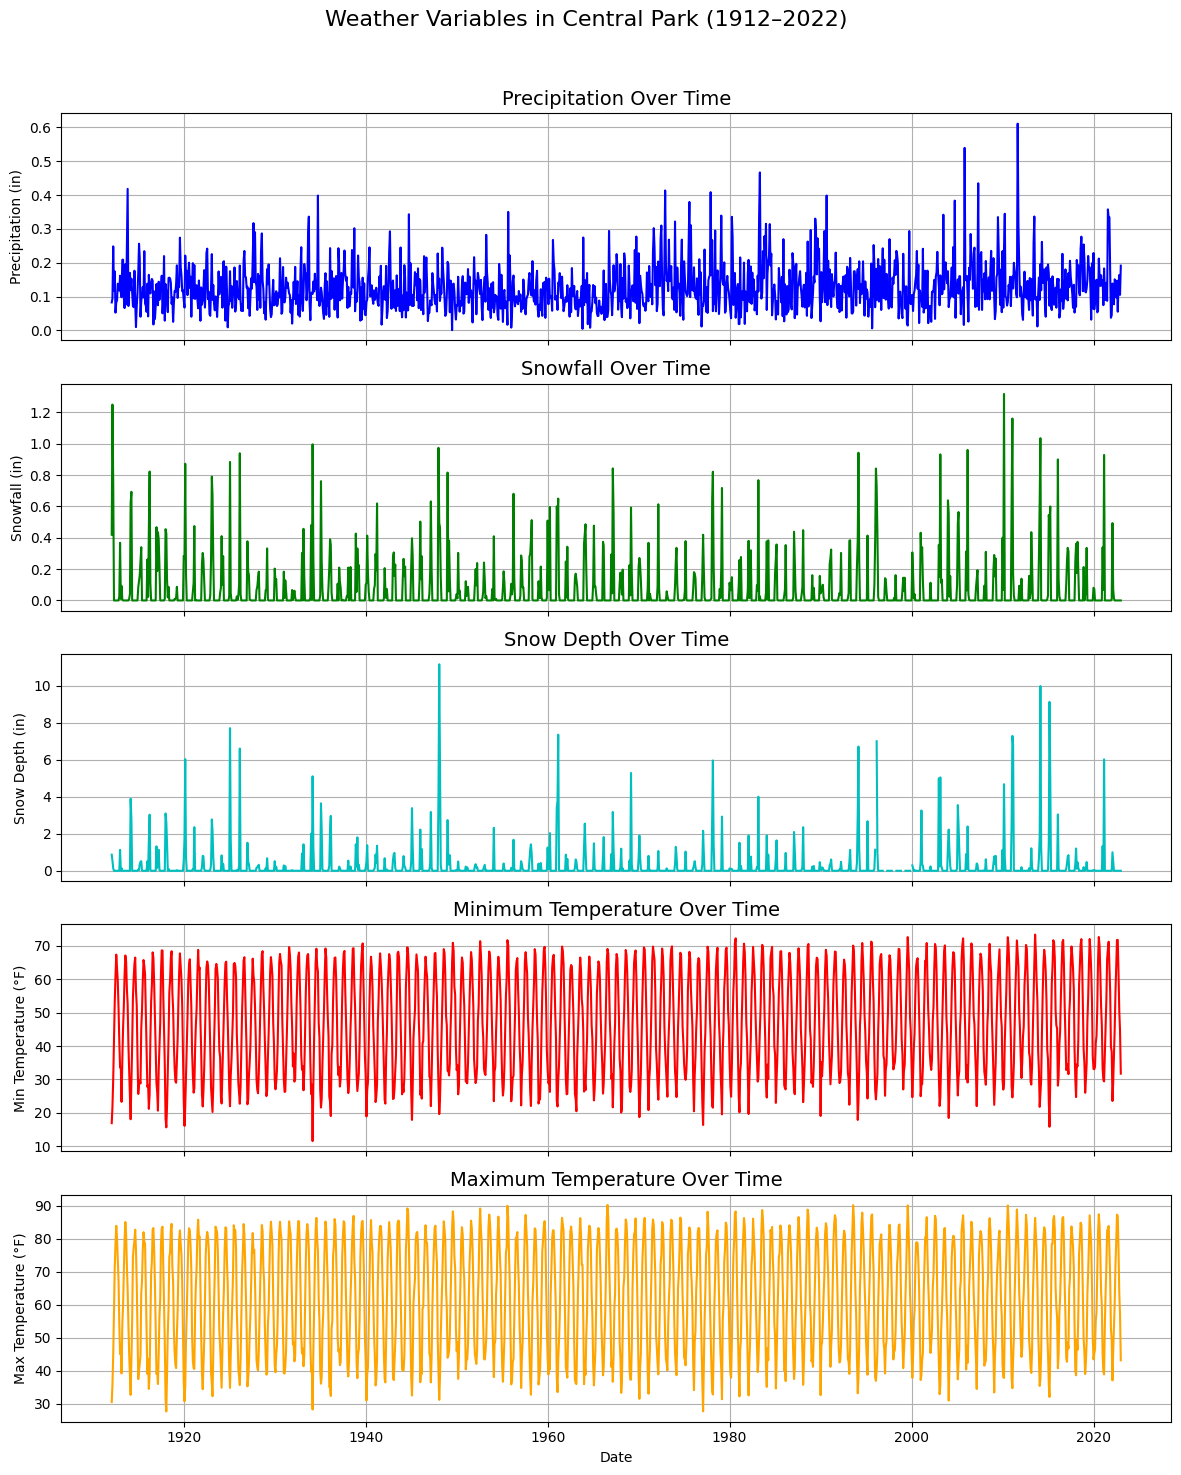

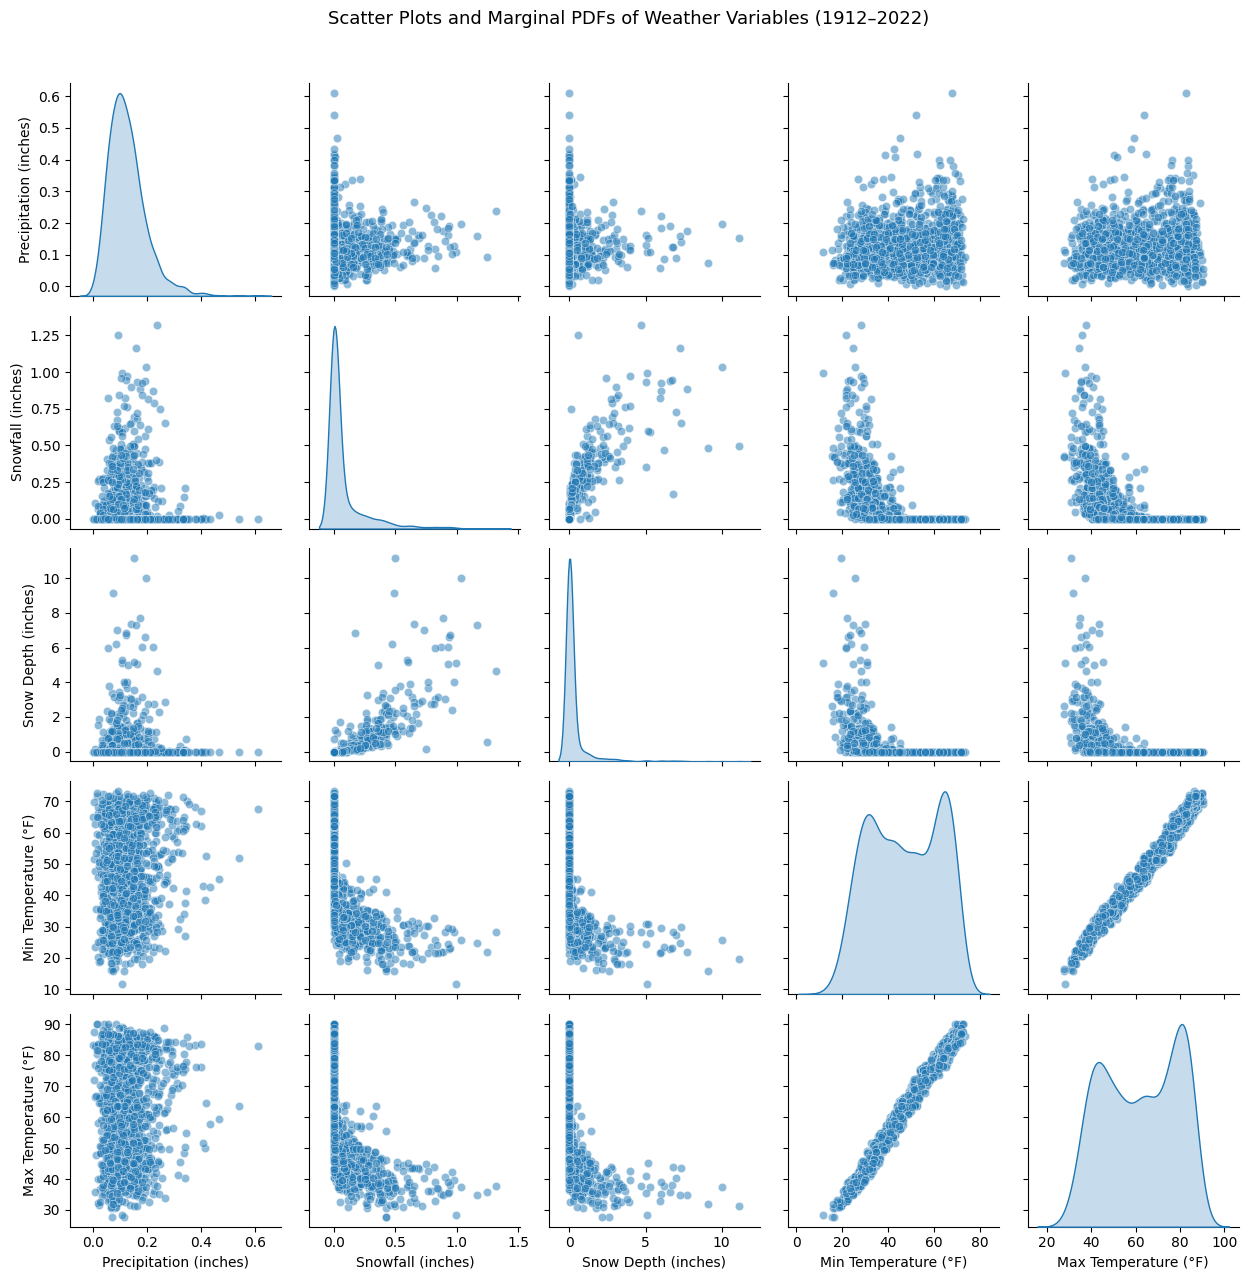

In [3]:
def visualize_data(weather_df_post_1912, temporal_resolution = "D"):
    weather_df_post_1912 = weather_df_post_1912.resample(temporal_resolution).mean()

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=True)
    fig.suptitle("Weather Variables in Central Park (1912–2022)", fontsize=16)

    # Plot Precipitation
    axes[0].plot(weather_df_post_1912.index, weather_df_post_1912['PRCP'], color='b', label='Precipitation')
    axes[0].set_ylabel("Precipitation (in)")
    axes[0].grid(True)
    axes[0].set_title("Precipitation Over Time", fontsize=14)

    # Plot Snowfall
    axes[1].plot(weather_df_post_1912.index, weather_df_post_1912['SNOW'], color='g', label='Snowfall')
    axes[1].set_ylabel("Snowfall (in)")
    axes[1].grid(True)
    axes[1].set_title("Snowfall Over Time", fontsize=14)

    # Plot Snow Depth
    axes[2].plot(weather_df_post_1912.index, weather_df_post_1912['SNWD'], color='c', label='Snow Depth')
    axes[2].set_ylabel("Snow Depth (in)")
    axes[2].grid(True)
    axes[2].set_title("Snow Depth Over Time", fontsize=14)

    # Plot Minimum Temperature
    axes[3].plot(weather_df_post_1912.index, weather_df_post_1912['TMIN'], color='r', label='Min Temp')
    axes[3].set_ylabel("Min Temperature (°F)")
    axes[3].grid(True)
    axes[3].set_title("Minimum Temperature Over Time", fontsize=14)

    # Plot Maximum Temperature
    axes[4].plot(weather_df_post_1912.index, weather_df_post_1912['TMAX'], color='orange', label='Max Temp')
    axes[4].set_ylabel("Max Temperature (°F)")
    axes[4].set_xlabel("Date")
    axes[4].grid(True)
    axes[4].set_title("Maximum Temperature Over Time", fontsize=14)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the figure
    # output_path = 'Post_1912.png'
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    columns_to_plot=['PRCP','SNOW','SNWD','TMIN','TMAX']

    # Rename columns for better readability
    weather_data_filtered = weather_df_post_1912[columns_to_plot]
    weather_data_filtered = weather_data_filtered.rename(columns={
        'PRCP': 'Precipitation (inches)',
        'SNOW': 'Snowfall (inches)',
        'SNWD': 'Snow Depth (inches)',
        'TMIN': 'Min Temperature (°F)',
        'TMAX': 'Max Temperature (°F)'
    })

    # Create a scatter plot matrix with KDE marginal distributions
    pairplot = sns.pairplot(
        weather_data_filtered,
        diag_kind="kde",  # KDE for marginal distributions
        plot_kws={"alpha": 0.5},  # transparency 
        diag_kws={"fill": True},  
        corner=False,  # Show all pairs
        height=2.5  
    )

    # Adjust the overall layout
    pairplot.fig.suptitle("Scatter Plots and Marginal PDFs of Weather Variables (1912–2022)", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()
# Visualize the data
weather_df_post_1912 = weather_df[weather_df.index.year >= 1912]
visualize_data(weather_df_post_1912, temporal_resolution="M")

In [8]:
# Add additional time-based features for analysis
weather_df_post_1912.loc[:, "day_of_year"] = weather_df_post_1912.index.dayofyear
weather_df_post_1912.loc[:, "month"] = weather_df_post_1912.index.month
weather_df_post_1912.loc[:, "year"] = weather_df_post_1912.index.year

# Derive the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

weather_df_post_1912.loc[:, "season"] = weather_df_post_1912["month"].apply(get_season)

# Ensure data is ordered chronologically
weather_df_post_1912.sort_index(inplace=True)
weather_df_post_1912

,PRCP,SNOW,SNWD,TMIN,TMAX,day_of_year,month,year,season
DATE,,,,,,,,,
1912-01-01,0.00,0.0,0.0,30.0,38.0,1,1,1912,4
1912-01-02,0.20,0.3,0.0,25.0,37.0,2,1,1912,4
1912-01-03,0.02,0.2,0.0,28.0,36.0,3,1,1912,4
1912-01-04,0.00,0.0,0.0,22.0,32.0,4,1,1912,4
1912-01-05,0.01,0.1,0.0,10.0,29.0,5,1,1912,4
...,...,...,...,...,...,...,...,...,...
2022-12-25,0.00,0.0,0.0,14.0,28.0,359,12,2022,4
2022-12-26,0.00,0.0,0.0,18.0,29.0,360,12,2022,4
2022-12-27,0.00,0.0,0.0,29.0,35.0,361,12,2022,4


In [5]:
features = ['PRCP', 'SNOW', 'SNWD', 'TMIN', 'TMAX', 'day_of_year', 'month',
            'year', 'season']

# Standardize the features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(weather_df_post_1912[features])

[      -inf 0.07147945 0.09013661 0.09273973 0.09391781 0.09668493
 0.09747945 0.09767123 0.09882192 0.09904372 0.09923288 0.0999726
 0.10065753 0.10106849 0.10178082 0.10345205 0.10355191 0.10441096
 0.10484932 0.10509589 0.10521858 0.10561644 0.10621918 0.10635616
 0.10671233 0.1069589  0.10772603 0.10931507 0.10931507 0.10978082
 0.11063014 0.11073973 0.11115068 0.11175342 0.11216438 0.11224658
 0.11243836 0.11278689 0.11342466 0.11350685 0.11355191 0.11372603
 0.11398907 0.11521858 0.11767123 0.11844262 0.11904372 0.11989041
 0.12002732 0.12035616 0.12131507 0.12172131 0.12204918 0.12235616
 0.12297814 0.12314208 0.12323288 0.12339726 0.12378082 0.12383562
 0.12383562 0.1239071  0.12418033 0.12453552 0.12464481 0.12528767
 0.12674863 0.12677686 0.12690411 0.12723288 0.12806011 0.12983562
 0.13065753 0.1310411  0.13284932 0.13290411 0.1329863  0.13339726
 0.13457534 0.13526027 0.13614754 0.13646575 0.13654795 0.14188525
 0.14282192 0.14512329 0.14528767 0.14535519 0.146      0.14647

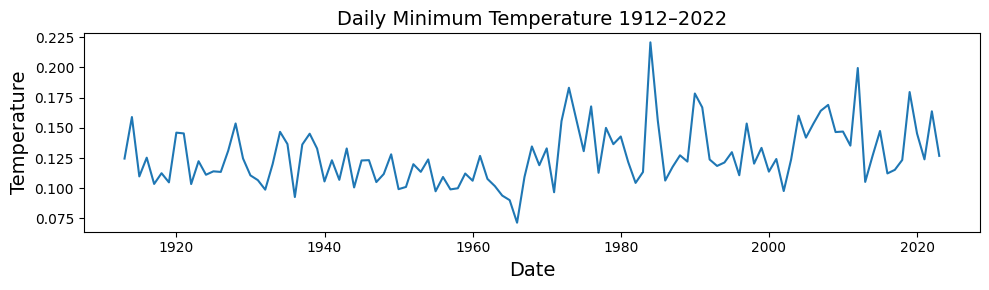

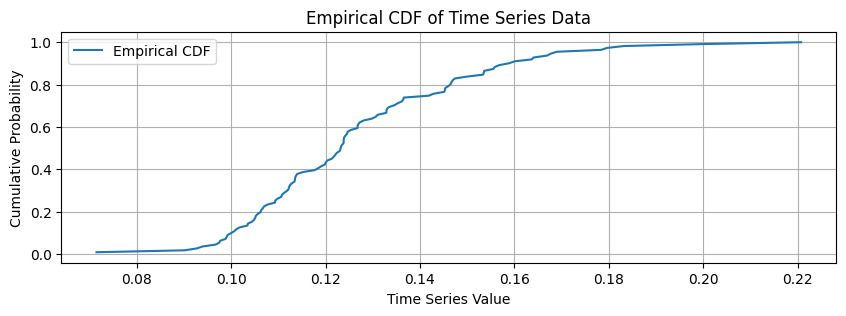

In [45]:
weather_df_post_2020 = weather_df[weather_df.index.year >= 1912]
df = weather_df_post_2020.copy().resample("YE").mean() 

df = df[['PRCP']]  # Select the precipitation column
df = df.dropna()   # Drop missing values
fontsize=14
plt.figure(figsize=(10,3), dpi=100)
plt.plot(df.index, df['PRCP'], label='PRCP')
plt.title("Daily Minimum Temperature 1912–2022", fontsize=fontsize)
plt.ylabel("Temperature", fontsize=fontsize)
plt.xlabel("Date", fontsize=fontsize)
plt.tight_layout()
from statsmodels.distributions.empirical_distribution import ECDF

# Compute the Empirical CDF
ecdf = ECDF(df['PRCP'].values)

print(ecdf.x)
print(ecdf.y)
# Plot the ECDF
plt.figure(figsize=(10, 3))
plt.plot(ecdf.x, ecdf.y, label="Empirical CDF")
plt.title("Empirical CDF of Time Series Data")
plt.xlabel("Time Series Value")
plt.ylabel("Cumulative Probability")
plt.grid()
plt.legend()
plt.show()

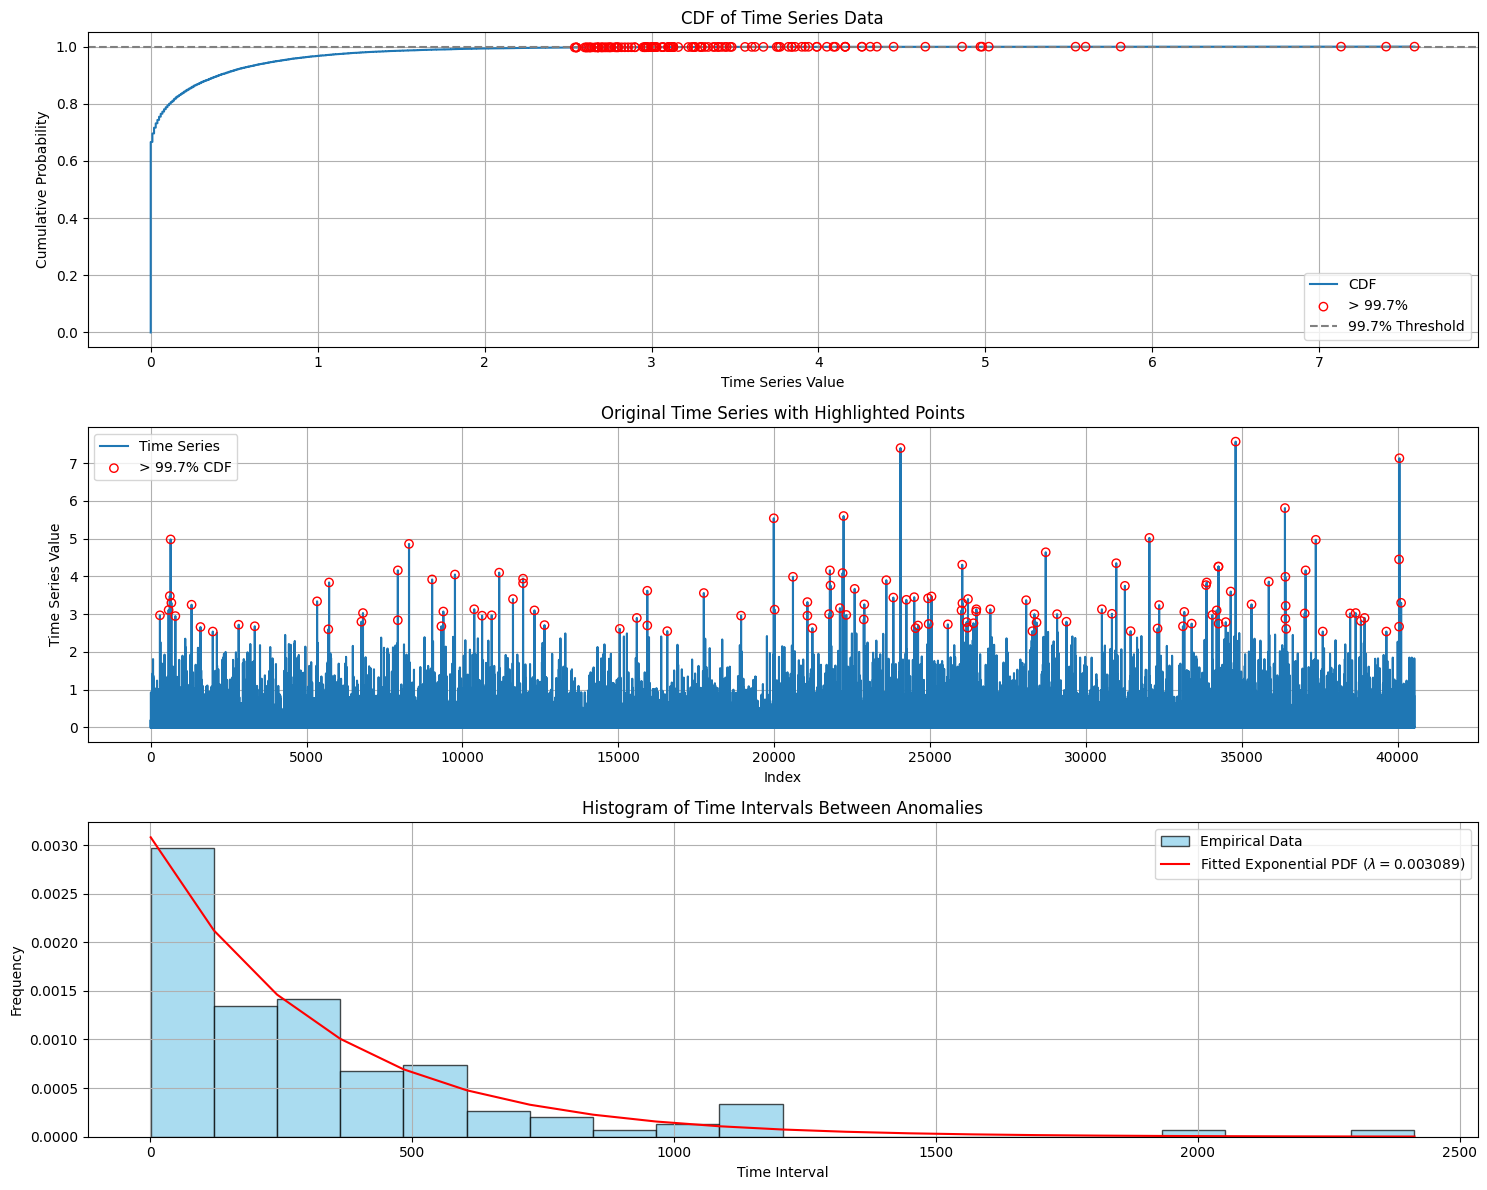

In [11]:
time_series = df['PRCP'].values
# Step 1: Sort the data and calculate the CDF
sorted_data = np.sort(time_series)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

threshold = 0.997
threshold_index = np.where(cdf > threshold)[0]  # Indices where CDF > 98%
threshold_values = sorted_data[threshold_index]  # Values above the threshold

# Step 3: Highlight these values on the original time series
highlight_indices = [i for i, x in enumerate(time_series) if x in threshold_values]
time_intervals = np.diff(highlight_indices)
# Step 4: Plot the CDF
plt.figure(figsize=(15, 12))

# CDF Plot
plt.subplot(3, 1, 1)
plt.plot(sorted_data, cdf, linestyle="-", label="CDF", alpha=1)
plt.scatter(threshold_values, cdf[threshold_index], edgecolors="red", facecolors='none', label=f"> {threshold*100}%", zorder=5)  # Highlight points
plt.title("CDF of Time Series Data")
plt.xlabel("Time Series Value")
plt.ylabel("Cumulative Probability")
plt.axhline(threshold, color="gray", linestyle="--", label=f"{threshold*100}% Threshold")
plt.grid()
plt.legend()

# Original Time Series Plot
plt.subplot(3, 1, 2)
plt.plot(time_series, label="Time Series")
plt.scatter(highlight_indices, time_series[highlight_indices], edgecolors="red", facecolors='none', label=f"> {threshold*100}% CDF", zorder=5)
plt.title("Original Time Series with Highlighted Points")
plt.xlabel("Index")
plt.ylabel("Time Series Value")
plt.grid()
plt.legend()


plt.subplot(3,1,3)
results = plt.hist(time_intervals, bins=20, color='skyblue', density = True, edgecolor='black', alpha=0.7, label="Empirical Data")
plt.title("Histogram of Time Intervals Between Anomalies")
plt.xlabel("Time Interval")
plt.ylabel("Frequency")
plt.grid()

from scipy.stats import expon

lam = 0.003089
x = results[1]
pdf = lam * np.exp(-lam * x)  # Manual calculation
pdf_scipy = expon.pdf(x, scale=1/lam)  # Using scipy (scale = 1/λ)
plt.plot(x, pdf, color="red", label=f"Fitted Exponential PDF ($\lambda={lam:.6f}$)")
plt.legend()

plt.tight_layout()
plt.show()


from scipy.stats import poisson

#### compare function

In [24]:
import functools
from typing import Any, Tuple

import numpy as np
from matplotlib import colorbar
import matplotlib.pyplot as plt
import scipy.signal as scipy_signal

# Useful helper functions.
def compare_signal_plot(
    signal: np.ndarray, reconstructed_signal: np.ndarray, signal_name: str
):
    time = np.arange(len(signal))
    fontsize = 14
    # fig, ax = plt.subplots(1, 2, figsize=(20, 3), dpi=100)
    # colors = ['#a1dab4', '#41b6c4', '#225ea8']
    
    # ax[0].plot(time, signal, label="PRCP", color=colors[0])
    # ax[0].plot(time, reconstructed_signal, label='Reconstructed Signal', color=colors[1])
    # ax[0].set_ylabel('Signal', fontsize=fontsize)
    # ax[0].legend(fontsize=10, loc='best', framealpha=1.0)
    # ax[0].set_ylim([0,8])
    
    # ax[1].plot(time, signal-reconstructed_signal, 
    #            label= 'PRCP - Reconstructed Signal', color=colors[1])
    # plt.axhline(0, c='k')
    # ax[1].set_ylabel('Error', fontsize=fontsize)
    # ax[1].legend(fontsize=10, loc=1, framealpha=1.0)
    # ax[1].set_ylim([-20,20])
    # ax[1].set_xlabel('Time', fontsize=fontsize)
    
    # plt.suptitle(signal_name, fontsize=fontsize)
    # plt.tight_layout()

    mse = np.mean((signal - reconstructed_signal)**2)
    mask = signal != 0
    mape = np.mean(np.abs((signal[mask] - reconstructed_signal[mask]) / signal[mask])) * 100
    return fig, mse, mape

def calculate_fourier_series(
    dt: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients using the Fourier transform.

    Args:
        dt: Interval between samples.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n, and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex. You may want to take advantage of the norm keyword.
    """
    # Placeholders.
    a_n = None
    b_n = None

    # TODO: Calculate the frequencies of each A_n and B_n. Remember that the
    # maximum frequency you can measure (and the maximum value numpy.fft will return
    # for real-valued signals) will be the Nyquist frequency.
    N = len(signal)
    frequencies = np.fft.rfftfreq(N, d=dt)   # TODO
    
    # TODO: Calculate the fourier series coefficients. Compare the equations from
    # the notes, and read the numpy.fft documentation carefully.
    fourier_transform = np.fft.rfft(signal)/N # TODO
    a_n = 2*fourier_transform.real
    b_n = -2*fourier_transform.imag

    return frequencies, a_n, b_n

def reconstructed_signal(
    frequency_mask: float, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return the signal with a mask applied to the Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        signal: Real signal at each point in time.

    Returns:
        Reconstructed signal after frequency mask has been applied.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not 
        complex.
    """    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation.
    N = len(signal)

    # Step 2: Compute Fourier Transform using np.fft.rfft
    fourier_transform = np.fft.rfft(signal)  # Normalize by the number of samples
    masked_spectrum =  fourier_transform*frequency_mask
    # Reconstruct the signal
    reconstructed_signal = np.fft.irfft(masked_spectrum, n=N)
    return reconstructed_signal

def plot_reconstructed_signal(mask, signal, magnitude, num_frequency):
    # find the top 20 frequencies index
    top_index = np.argsort(magnitude)[::-1][:num_frequency]
    mask[top_index] = 1
    reconstructed_tmin = reconstructed_signal(mask, df['PRCP'].values)
    fig, mse, mape = compare_signal_plot(df['PRCP'].values, reconstructed_tmin, f'Reconstructed signal with top {num_frequency} frequencies')
    return fig, mse, mape

def create_gif(mask, signal, magnitude, num_frequencies, output_filename="reconstructed_signal.gif"):
    frames = []  # List to store the frames for the GIF
    mse_list = []  # List to store the MSE values
    mape_list = []  # List to store the MAPE values
    # Loop over `num_frequency` values
    for num_frequency in num_frequencies:        
        # Plot the reconstructed signal for the current `num_frequency`
        fig, mse, mape = plot_reconstructed_signal(mask.copy(), signal, magnitude, num_frequency)

        mse_list.append(mse)
        mape_list.append(mape)
    #     fig.savefig(f"frame_{num_frequency}.png")  # Temporarily save the frame as an image
    #     frames.append(f"frame_{num_frequency}.png")  # Store the filename
    #     plt.close(fig)  # Close the plot to avoid overlapping
    
    # # Combine the frames into a GIF
    # from PIL import Image
    # images = [Image.open(frame) for frame in frames]
    # images[0].save(output_filename, save_all=True, append_images=images[1:], duration=200, loop=0)

    # # Clean up temporary files
    # for frame in frames:
    #     import os
    #     os.remove(frame)

    # print(f"GIF saved as {output_filename}")

    return mse_list, mape_list

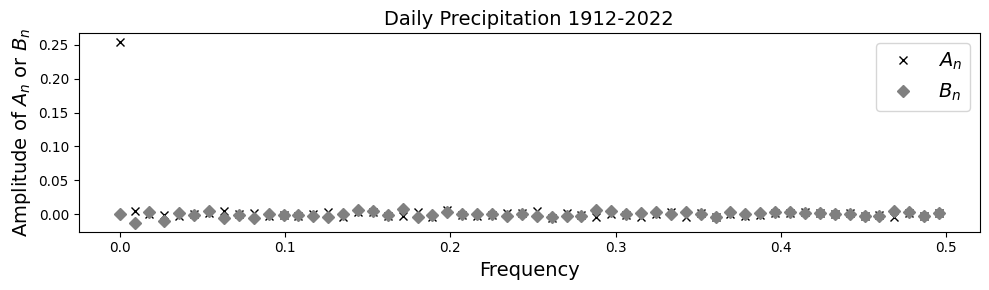

In [46]:
from matplotlib.animation import FuncAnimation, PillowWriter

fontsize = 14
dt = 1
frequencies, a_n_sntv, b_n_sntv = calculate_fourier_series(dt, df['PRCP'].values)
frequencies_to_plot = frequencies
a_n_to_plot = a_n_sntv
b_n_to_plot = b_n_sntv

plt.figure(figsize=(10,3), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=1)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=1)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.legend(fontsize=fontsize)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=fontsize)
plt.xlabel('Frequency', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize * 0.7)
plt.title('Daily Precipitation 1912-2022', fontsize=fontsize)
plt.tight_layout()
plt.show()

magnitude = a_n_sntv**2 + b_n_sntv**2
mask = np.zeros(int(len(df['PRCP'].values)/2+1))

yearly_frequencies = frequencies
num_frequencies = range(1, len(frequencies),10)
mse_list, mape_list = create_gif(mask, df['PRCP'].values, magnitude, num_frequencies, output_filename="daily_reconstructed_signal.gif")
yearly_mse = mse_list
yearly_mape = mape_list


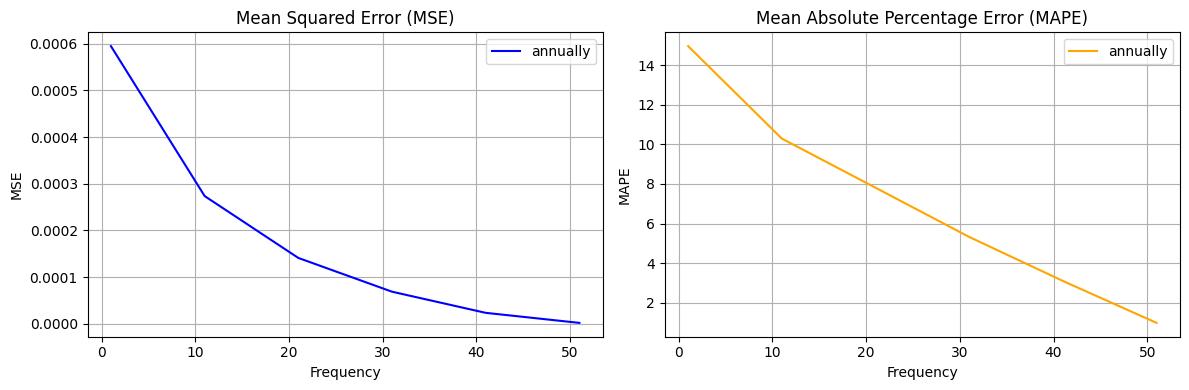

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First subplot: MSE
# axes[0].plot(range(1, len(daily_frequencies), 500), daily_mse, label='daily', color='blue')
# axes[0].plot(range(1, len(monthly_frequencies), 10), monthly_mse, label='monthly', color='blue')
axes[0].plot(range(1, len(yearly_frequencies), 10), yearly_mse, label='annually', color='blue')
axes[0].set_title("Mean Squared Error (MSE)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("MSE")
axes[0].legend()
axes[0].grid()

# Second subplot: MAPE
# axes[1].plot(range(1, len(daily_frequencies), 500), daily_mape, label='daily', color='orange')
# axes[1].plot(range(1, len(monthly_frequencies), 10), monthly_mape, label='monthly', color='orange')
axes[1].plot(range(1, len(yearly_frequencies), 10), yearly_mape, label='annually', color='orange')
axes[1].set_title("Mean Absolute Percentage Error (MAPE)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("MAPE")
axes[1].legend()
axes[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In [245]:
def calculate_time_varying_fourier_series(
    dt: float, n_steps_per_seg: int, noverlap: int, signal: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the Fourier series coefficients in multiple segments.

    Args:
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n and B_n coefficients for the fourier series 
        representaiton.

    Notes:
        Take advantage of scipy.signal.stft. You will want to use a boxcar
        window and ensure no overlap between the windows. Check the stft
        documentation for hints.
    """
    # Placeholders.
    a_n_t = None
    b_n_t = None
    frequencies = None
    time_segments = None

    N = len(signal)
    
    # TODO: Calculate the Fourier series coefficients for each segment. Remember 
    # to use a boxcar window and set the overlap to zero.
    frequencies, time_segments, fourier_segments = scipy_signal.stft(signal, fs=1/dt,window="hann", nperseg=n_steps_per_seg, noverlap=noverlap)
    a_n_t = 2*fourier_segments.real
    b_n_t = -2*fourier_segments.imag

    return frequencies, time_segments, a_n_t, b_n_t

def reconstructed_time_varying_signal(
    frequency_mask: np.ndarray, dt: float, n_steps_per_seg: int, signal: np.ndarray
) -> Tuple[np.ndarray]:
    """Return the signal with a mask applied to the short-time Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        dt: Interval between samples.
        n_steps_per_seg: Number of time steps in each segment.
        signal: Real signal at each point in time.

    Returns:
        Signal after frequency mask has been applied.

    Notes:
        Take advantage of scipy.signal.stft and scipy.signal.istft. Remember
        to use the boxcar window and no overlap.
    """    
    frequency_mask = frequency_mask[:, np.newaxis]

    frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, signal)

    masked_a_n = a_n_t*frequency_mask/2
    masked_b_n = b_n_t*frequency_mask/2

    # Placeholder
    stft_reconstruction = scipy_signal.istft(masked_a_n + 1j*masked_b_n, fs=1/dt, window='boxcar', nperseg=n_steps_per_seg, noverlap=0)[1]
    
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation. You will need to add a
    # new axis to the mask.
    # raise ValueError('Write the code')
    return stft_reconstruction

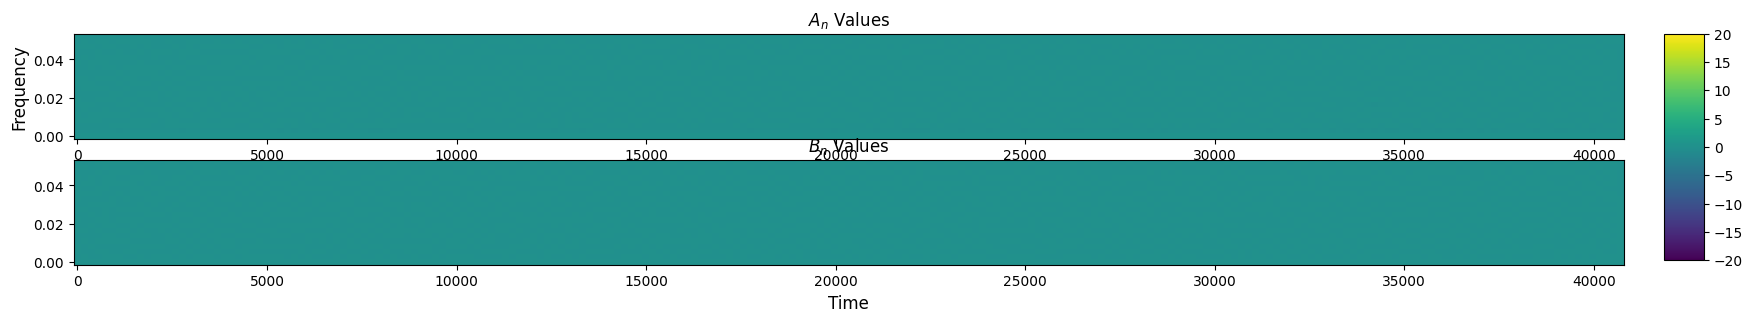

In [420]:
n_steps_per_seg = 365
noverlap = 180
dt = 1
frequencies, time_segments, a_n_t, b_n_t = calculate_time_varying_fourier_series(dt, n_steps_per_seg, noverlap, df['PRCP'].values)

fontsize = 12
fig, ax = plt.subplots(2, 1, figsize=(20, 3), dpi=100)

ax[0].pcolormesh(time_segments, frequencies[:20], a_n_t[:20], vmin=-20, vmax=20)
ax[0].set_title(r'$A_n$ Values', fontsize=fontsize)
ax[0].set_ylabel('Frequency', fontsize=fontsize)
ax[0].set_xlabel('Time', fontsize=fontsize)
pcm = ax[1].pcolormesh(time_segments, frequencies[:20], b_n_t[:20], vmin=-20, vmax=20)
ax[1].set_title(r'$B_n$ Values', fontsize=fontsize)
ax[1].set_xlabel('Time', fontsize=fontsize)


cbar_ax = fig.add_axes([0.92, 0.125, 0.02, 0.755])
fig.colorbar(pcm, cax=cbar_ax)
fig.subplots_adjust(wspace=0.0)
plt.show()

In [ ]:


stft_reconstruction = reconstructed_time_varying_signal(mask, dt, n_steps_per_seg, df['PRCP'].values)

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       ])

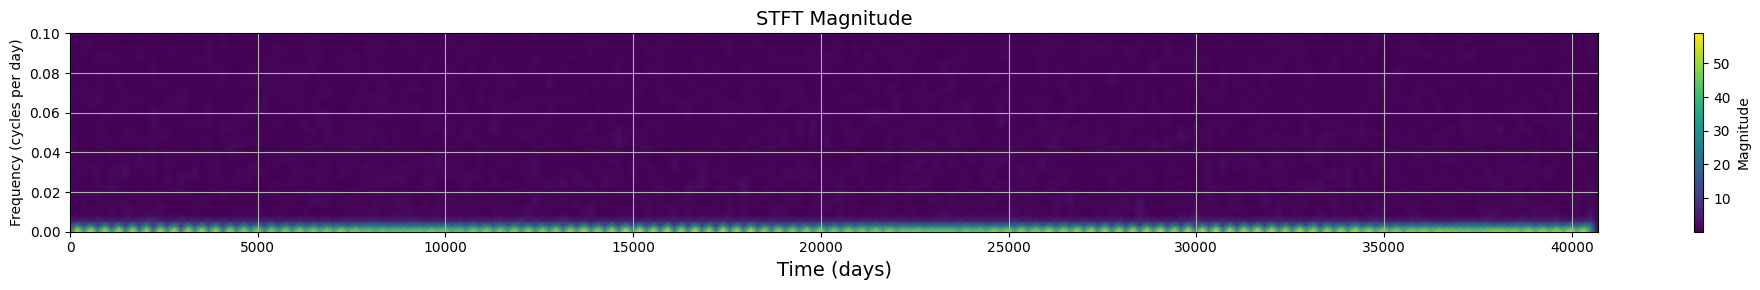

In [457]:
data = df['TMIN'].values
fontsize = 14
fs = 1  # Sampling frequency (1 sample per month)
nperseg = 365  # Segment length (2 years)
f, t, Zxx = scipy_signal.stft(data, fs=fs, nperseg=nperseg, noverlap=180)

# Step 2: Visualize the frequency and magnitude
plt.figure(figsize=(20, 3))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')  # Convert frequency to cycles/year
plt.title("STFT Magnitude", fontsize=fontsize)
plt.ylabel("Frequency (cycles per day)", fontsize=10)
plt.xlabel("Time (days)", fontsize=fontsize)
plt.colorbar(label="Magnitude")
plt.ylim([0, 0.1])  # Limit the frequency range
plt.grid()
plt.tight_layout()
plt.show()

# # Step 3: Identify the top 10 largest magnitudes
# magnitudes = np.abs(Zxx)  # Compute the magnitude of each coefficient
# flat_indices = np.argsort(magnitudes.ravel())  # Indices of the 10 largest magnitudes

# # Create a mask for the top 10 components
# mask = np.zeros_like(Zxx, dtype=bool)
# mask[np.unravel_index(flat_indices, Zxx.shape)] = True

# # Apply the mask to the STFT
# Zxx_masked = Zxx * mask  # Keep only the top 10 magnitudes

# # Step 4: Reconstruct the signal using ISTFT
# _, reconstructed_data = scipy_signal.istft(Zxx_masked, fs=fs)

# # Step 5: Visualize the original and reconstructed signal
# plt.figure(figsize=(12, 8))

# # Original Signal
# plt.subplot(2, 1, 1)
# plt.plot(range(len(df['TMIN'].values)), data, label="Original Data")
# plt.title("Original Monthly Data")
# plt.xlabel("Months")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.legend()

# # Reconstructed Signal
# plt.subplot(2, 1, 2)
# plt.plot(range(len(df['TMIN'].values)), reconstructed_data, label="Reconstructed Data (Top 10 Components)", color="orange")
# plt.title("Reconstructed Data using Top 10 STFT Magnitudes")
# plt.xlabel("Months")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Optional: Print the top frequencies and magnitudes
# top_frequencies = f[np.unravel_index(flat_indices, Zxx.shape)[0]] * 12  # Convert to cycles/year
# print("Top 10 Frequencies (cycles/year):", top_frequencies)
# print("Top 10 Magnitudes:", magnitudes[np.unravel_index(flat_indices, Zxx.shape)])

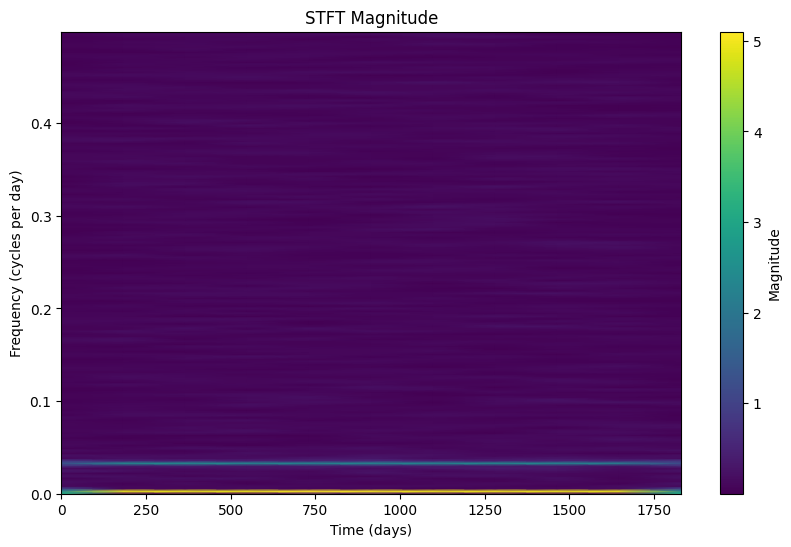

In [424]:
np.random.seed(42)
days = 5 * 365
time = np.arange(days)
signal = 10 * np.sin(2 * np.pi * time / 365) + 5 * np.sin(2 * np.pi * time / 30) + np.random.normal(0, 2, days)

# Parameters for STFT
dt = 1  # Sampling interval (daily data)
nperseg = 365  # 1-year segment
noverlap = 182  # 50% overlap

# Compute STFT
frequencies, times, Zxx = scipy_signal.stft(signal, fs=1 / dt, window='boxcar', nperseg=nperseg, noverlap=noverlap)

# Plot STFT magnitude
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.abs(Zxx), shading='gouraud')
plt.title("STFT Magnitude")
plt.ylabel("Frequency (cycles per day)")
plt.xlabel("Time (days)")
plt.colorbar(label="Magnitude")
plt.show()

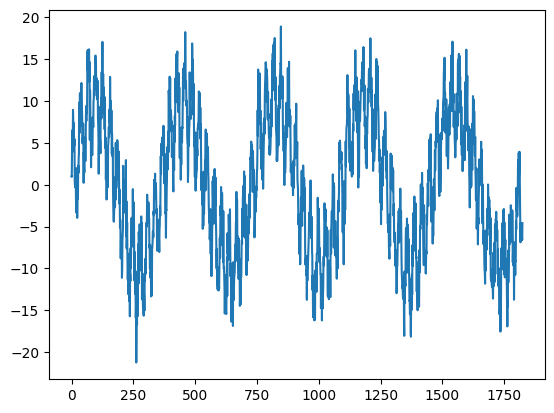

In [425]:
plt.plot(signal)

In [136]:
a_n_t.min()

-0.02700402059203305

In [138]:
b_n_t.max()

0.07607580740372172